# Import libraries

In [1]:
import sys

sys.path.insert(0,'..')
#!pip install openpyxl

In [2]:

import matplotlib.pyplot as plt

from lhcsmapi.Time import Time

from src.utils.hdf_tools import load_from_hdf_with_regex, u_diode_data_to_df
from src.modeling.sec_quench import *
from src.visualisation.sec_quench_visualisation import plot_wiggle_analysis

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')

# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / '20220707_data'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

4763

# Select events to analyze

In [5]:
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 

mp3_fpa_df_period_all = mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
print(len(mp3_fpa_df_period), len(mp3_fpa_df_period_all))

896 4379


In [6]:
# Add information, whether download was successfull
df_acquisition = pd.read_excel("../data/20220707_acquisition_summary.xlsx")
mp3_fpa_df_period_merged = mp3_fpa_df_period.merge(df_acquisition , left_on=['Circuit Name', 'timestamp_fgc'], right_on=['Circuit Name', 'timestamp_fgc'], how="left")
df_to_analyze = mp3_fpa_df_period_merged[mp3_fpa_df_period_merged["VoltageNXCALS.*U_DIODE"]==1]

# Analyze all events

In [ ]:
df_results = mp3_fpa_df_period_all[['Circuit Family','Circuit Name','timestamp_fgc','Position']]
time_frame_after_quench = [0, 2]

for k, row in df_to_analyze.iterrows():
    
    circuit_name = row['Circuit Name']
    timestamp_fgc = int(row['timestamp_fgc'])
    fpa_identifier = f"{row['Circuit Family']}_{row['Circuit Name']}_{int(row['timestamp_fgc'])}"
    
    data_dir = data_path / (fpa_identifier + ".hdf5")
    data = load_from_hdf_with_regex(file_path=data_dir, regex_list=["VoltageNXCALS.*U_DIODE"])
    df_data_nxcals = u_diode_data_to_df(data)
    
    df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == timestamp_fgc) & (mp3_fpa_df["Circuit Name"] == circuit_name)]
    print(f"{k}/{len(df_to_analyze)} {fpa_identifier} n_quenches:{len(df_subset)} len_data:{len(df_data_nxcals)}")
    
    quench_times = df_subset["Delta_t(iQPS-PIC)"].values /1e3
    sec_quenches = get_sec_quench_frame_exclude_quench(df_data=df_data_nxcals, 
                                     all_quenched_magnets=df_subset.Position.values, 
                                     quench_times=quench_times, 
                                     time_frame=time_frame_after_quench)
    
    for sec_quench_number, df_quench_frame in enumerate(sec_quenches):
        if not df_quench_frame.empty:
            df_results_new = get_sec_quench_features(df_quench_frame=df_quench_frame,
                                                     df_mp3_subset=df_subset,
                                                     time_frame_after_quench=time_frame_after_quench,
                                                     sec_quench_number=sec_quench_number)
            df_results = pd.concat([df_results, df_results_new])

df_results.dropna().to_csv("../data/sec_quench_feature.csv")

# Read results define plotting function

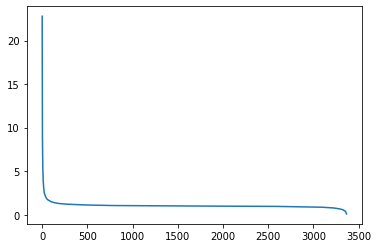

In [7]:
df_results= pd.read_csv("../data/sec_quench_feature.csv").drop(columns="Unnamed: 0")
#df_results= pd.read_csv("sec_quench_features.csv").drop(columns="Unnamed: 0")

df_results = df_results.sort_values(by='dstd_score_pos_15', ascending=False).reset_index(drop=True)
df_results = df_results.merge(df_acquisition, left_on=["Circuit Name", 'timestamp_fgc'], right_on=["Circuit Name", 'timestamp_fgc'], how="left") 

df_results.dstd_score_pos_15.plot(legend=False)


features = ["start_time", 'min_time', 'max_time', 'min_amplitude', 'max_amplitude', "dU_min", "dU_max", "dstd_max",  'dstd_score_pos_15', 'dstd_score_elpos_15', 'dstd_score_pos_15_exp', 
           'dstd_score_elpos_15_exp','dstd_score_pos_15_tuk', 'dstd_score_elpos_15_tuk', 'wiggle_area_pos','wiggle_area_elpos', "el_peak12_ratio", "n_other_quenches","wiggle_magnets"]

#features = ['dstd_score_pos_15', 'dstd_score_elpos_15', 'dstd_score_pos_15_exp', "el_peak12_ratio", "n_other_quenches","wiggle_magnets"]
#features = ["dstd_score_pos_15_tuk", "dstd_score_elpos_15_tuk", "start_time", "dstd_max", "n_other_quenches", "el_peak12_ratio", "wiggle_magnets"]

# Type 1 oscillation, propagation only electrically

3


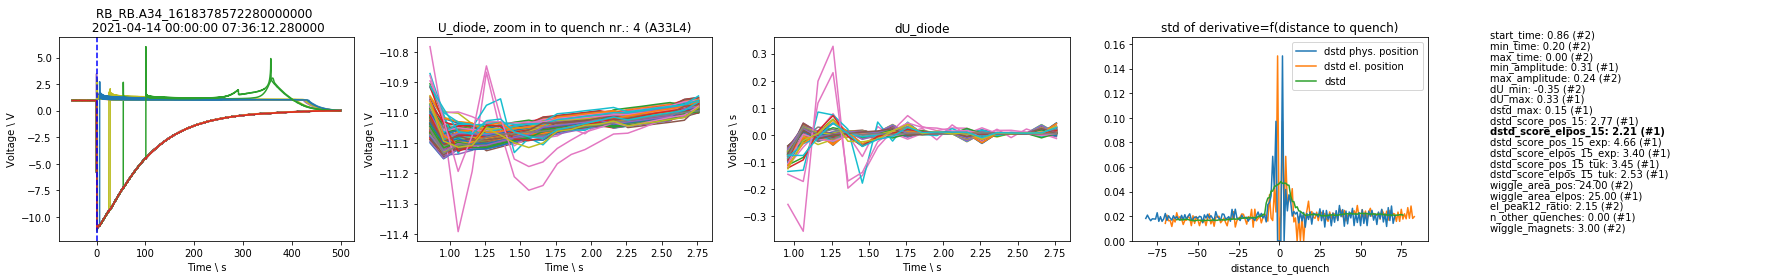

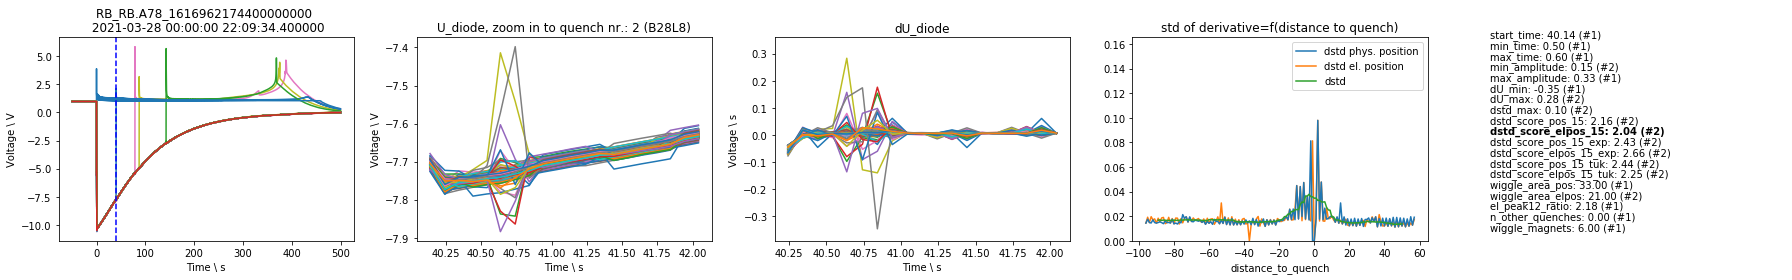

In [8]:
sort_feature = 'dstd_score_elpos_15'
df_plot = df_results.sort_values(by=sort_feature, ascending=False).reset_index(drop=True)

show_n_quenches = 2

# define manual thresholds to find type 1
df_plot = df_plot[df_plot["VoltageNXCALS.*U_DIODE"]==1]
df_plot = df_plot[df_plot["start_time"]>=0.5]
df_plot = df_plot[df_plot["dstd_max"]>=0.05]
df_plot = df_plot[df_plot["n_other_quenches"]<1]
df_plot = df_plot[df_plot["el_peak12_ratio"]>=2]
df_plot = df_plot[df_plot["wiggle_magnets"]>1]

print(len(df_plot))

plot_wiggle_analysis(
    mp3_fpa_df=mp3_fpa_df,
    df_results=df_plot,
    data_path=data_path,
    show_n_quenches=show_n_quenches,
    features=features,
    sort_feature=sort_feature)

# Type 2 Oscillation that propagates physically and electrically

In [ ]:
sort_feature = 'dstd_score_pos_15'
df_plot = df_results.sort_values(by=sort_feature, ascending=False).reset_index(drop=True)

show_n_quenches = 20

# Filter
df_plot = df_plot[df_plot.max_time!=0]
df_plot = df_plot[df_plot["VoltageNXCALS.*U_DIODE"]==1]
df_plot = df_plot[df_plot["start_time"]>=10]
df_plot = df_plot[df_plot["dstd_max"]>=0.02]
df_plot = df_plot[df_plot["el_peak12_ratio"]<2]
df_plot = df_plot[df_plot["n_other_quenches"]<1]
df_plot = df_plot[df_plot["wiggle_magnets"]>1]
df_plot = df_plot[df_plot["wiggle_magnets"]>1]


print(len(df_plot))

plot_wiggle_analysis(
    mp3_fpa_df=mp3_fpa_df,
    df_results=df_plot,
    data_path=data_path,
    show_n_quenches=show_n_quenches,
    features=features,
    sort_feature=sort_feature)

# Type 3 Oscillation in only one magnet 

In [ ]:
sort_feature = 'dstd_score_pos_15_exp'
df_plot = df_results.sort_values(by=sort_feature, ascending=False).reset_index(drop=True)

show_n_quenches = 5

# Filter
df_plot = df_plot[df_plot["VoltageNXCALS.*U_DIODE"]==1]
df_plot = df_plot[df_plot["start_time"]>=0.5]
df_plot = df_plot[df_plot["el_peak12_ratio"]<2]
df_plot = df_plot[df_plot["n_other_quenches"]<1]
df_plot = df_plot[df_plot["wiggle_magnets"]==1]
print(len(df_plot))

plot_wiggle_analysis(
    mp3_fpa_df=mp3_fpa_df,
    df_results=df_plot,
    data_path=data_path,
    show_n_quenches=show_n_quenches,
    features=features,
    sort_feature=sort_feature)

# Type 3 Oscillation due to another quench in time window

In [ ]:
sort_feature = 'n_other_quenches'
df_plot = df_results.sort_values(by=sort_feature, ascending=False).reset_index(drop=True)

show_n_quenches = 5
df_plot = df_plot[df_plot["VoltageNXCALS.*U_DIODE"]==1]
df_plot = df_plot[df_plot["start_time"]>=0.5]
df_plot = df_plot[df_plot["dstd_max"]>0.05]
df_plot = df_plot[df_plot["el_peak12_ratio"]<=1.5]
print(len(df_plot))

plot_wiggle_analysis(
    mp3_fpa_df=mp3_fpa_df,
    df_results=df_plot,
    data_path=data_path,
    show_n_quenches=show_n_quenches,
    features=features,
    sort_feature=sort_feature)

# Type 4 Oscillation due to acquisition

In [ ]:
sort_feature = 'dstd_score_pos_15'
df_plot = df_results.sort_values(by=sort_feature, ascending=False).reset_index(drop=True)

show_n_quenches = 5
df_plot = df_plot[df_plot["VoltageNXCALS.*U_DIODE"]==1]
df_plot = df_plot[df_plot["dstd_max"]<0.02]
df_plot = df_plot[df_plot["start_time"]>=0.5]
df_plot = df_plot[df_plot["el_peak12_ratio"]<2]
df_plot = df_plot[df_plot["n_other_quenches"]<1]
print(len(df_plot))

plot_wiggle_analysis(
    mp3_fpa_df=mp3_fpa_df,
    df_results=df_plot,
    data_path=data_path,
    show_n_quenches=show_n_quenches,
    features=features,
    sort_feature=sort_feature)

# Other analysis

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
scaler = StandardScaler()
df_tsne = df_results.copy()

# Filter
#df_tsne = df_tsne[df_tsne["start_time"]>=0.5]
#df_tsne = df_tsne[df_tsne["dstd_max"]>=0.02]
#df_tsne = df_tsne[df_tsne["n_other_quenches"]<1]
print(len(df_tsne))

df_tsne[features] = scaler.fit_transform(df_tsne[features])
X = df_tsne[features].to_numpy(dtype=np.float64)

X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

In [ ]:
plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1])

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_embedded)
centers = kmeans.cluster_centers_

center_indices=[]

for i, center in enumerate(centers):
    distance = np.linalg.norm(X_embedded - centers[i:i + 1, :], axis=1)
    center_indices.append(np.argsort(distance)[0])

In [ ]:
plot_wiggle_analysis(
    mp3_fpa_df=mp3_fpa_df,
    df_results=df_tsne.iloc[center_indices],
    data_path=data_path,
    show_n_quenches=show_n_quenches,
    features=features,
    sort_feature=sort_feature)